# End-to-End Regression Pipeline — Midterm Regresi Dataset

## Objective
Membangun pipeline regresi end-to-end untuk memprediksi **target kontinu** (contoh: **tahun rilis lagu**) dari fitur numerik audio.

## Dataset
File: `midterm-regresi-dataset.csv`

Karakteristik:
- Dataset **tanpa header**
- Kolom pertama = **target** (contoh: 2001 → tahun rilis)
- Kolom-kolom setelahnya = **fitur numerik** (feature_1, feature_2, ..., feature_n)

## Workflow (sesuai instruksi tugas)
1. Load data
2. Data cleaning & preprocessing:
   - cek missing values
   - handle outliers
   - feature scaling
3. Split train/valid/test
4. Modeling:
   - baseline model
   - model utama
5. Basic hyperparameter tuning
6. Evaluation:
   - MAE, MSE, RMSE, R²
7. Interpretasi hasil + visualisasi prediksi


In [1]:
!pip -q install gdown

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.base import BaseEstimator, TransformerMixin


## Download Dataset

Dataset didownload dari Google Drive menggunakan `gdown`.
Jika file sudah ada di environment, cell ini aman dijalankan (akan overwrite / skip tergantung kondisi).


In [2]:
import gdown
import os

FILE_ID = "1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9"
file_path = "midterm-regresi-dataset.csv"

if not os.path.exists(file_path):
    url = f"https://drive.google.com/uc?id={FILE_ID}"
    gdown.download(url, file_path, quiet=False)
else:
    print("File already exists:", file_path)

print("File path:", file_path)


Downloading...
From (original): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9
From (redirected): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9&confirm=t&uuid=6167750f-4799-4c9f-a643-48c6fd5bcf3d
To: /content/midterm-regresi-dataset.csv
100%|██████████| 443M/443M [00:07<00:00, 56.2MB/s]

File path: midterm-regresi-dataset.csv


## Load Data

Karena dataset tidak punya header, kita load dengan `header=None`.
Kemudian kita beri nama kolom:
- `target`
- `feature_1 ... feature_n`


In [3]:
df = pd.read_csv(file_path, header=None, low_memory=False)

print("Shape:", df.shape)
display(df.head())

# kolom pertama = target
target_col = 0
X_cols = list(range(1, df.shape[1]))

# rename
col_names = ["target"] + [f"feature_{i}" for i in range(1, df.shape[1])]
df.columns = col_names

df.head()


Shape: (515345, 91)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


## Quick EDA

Kita cek:
- tipe data
- missing values
- ringkasan statistik target (min/max/mean)
- distribusi target (sample)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   target      515345 non-null  int64  
 1   feature_1   515345 non-null  float64
 2   feature_2   515345 non-null  float64
 3   feature_3   515345 non-null  float64
 4   feature_4   515345 non-null  float64
 5   feature_5   515345 non-null  float64
 6   feature_6   515345 non-null  float64
 7   feature_7   515345 non-null  float64
 8   feature_8   515345 non-null  float64
 9   feature_9   515345 non-null  float64
 10  feature_10  515345 non-null  float64
 11  feature_11  515345 non-null  float64
 12  feature_12  515345 non-null  float64
 13  feature_13  515345 non-null  float64
 14  feature_14  515345 non-null  float64
 15  feature_15  515345 non-null  float64
 16  feature_16  515345 non-null  float64
 17  feature_17  515345 non-null  float64
 18  feature_18  515345 non-null  float64
 19  fe

,0
target,0.0
feature_1,0.0
feature_2,0.0
feature_3,0.0
feature_4,0.0
feature_5,0.0
feature_6,0.0
feature_7,0.0
feature_8,0.0
feature_9,0.0



Target summary:


,target
count,515345.000000
mean,1998.397082
std,10.931046
min,1922.000000
25%,1994.000000
50%,2002.000000
75%,2006.000000
max,2011.000000


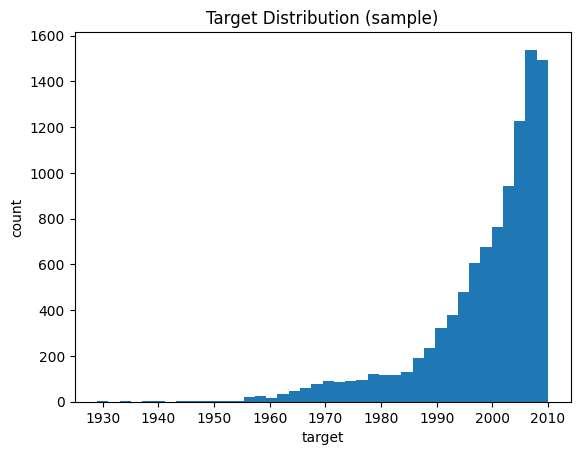

In [4]:
print(df.info())

missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("\nTop 10 missing columns (%):")
display(missing_pct.head(10))

print("\nTarget summary:")
display(df["target"].describe())

# plot distribusi target (sample supaya cepat)
sample_target = df["target"].sample(n=min(10000, len(df)), random_state=42)
plt.figure()
plt.hist(sample_target, bins=40)
plt.title("Target Distribution (sample)")
plt.xlabel("target")
plt.ylabel("count")
plt.show()


## Train/Validation/Test Split

Kita split dataset menjadi:
- Train: 80%
- Validation: 10%
- Test: 10%

Validation dipakai untuk pemilihan model/tuning.
Test dipakai untuk evaluasi final (lebih “fair”).


In [5]:
X = df.drop(columns=["target"])
y = df["target"].astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42
)  # 0.1111 of 90% ~ 10% total

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test :", X_test.shape,  y_test.shape)


Train: (412280, 90) (412280,)
Valid: (51530, 90) (51530,)
Test : (51535, 90) (51535,)


## Handling Outliers (Quantile Clipping)

Untuk fitur numerik, outlier bisa membuat model (terutama linear model) kurang stabil.

Strategi yang dipakai:
- **Quantile clipping (winsorize)** pada fitur:
  - clip ke rentang [0.5% quantile, 99.5% quantile] berdasarkan data train

Keuntungan:
- mengurangi pengaruh nilai ekstrim
- tetap mempertahankan sebagian besar informasi data


In [6]:
class QuantileClipper(BaseEstimator, TransformerMixin):
    """
    Clip setiap kolom ke [low_q, high_q] berdasarkan quantile data train.
    Bekerja pada numpy array (setelah imputer).
    """
    def __init__(self, low_q=0.005, high_q=0.995):
        self.low_q = low_q
        self.high_q = high_q
        self.low_ = None
        self.high_ = None

    def fit(self, X, y=None):
        X = np.asarray(X)
        self.low_ = np.nanquantile(X, self.low_q, axis=0)
        self.high_ = np.nanquantile(X, self.high_q, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X)
        return np.clip(X, self.low_, self.high_)


## Evaluation Metrics

Kita gunakan metrik regresi sesuai instruksi:
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)
- R² (coefficient of determination)

Interpretasi singkat:
- MAE/RMSE/MSE lebih kecil → lebih baik
- R² mendekati 1 → lebih baik (0 artinya setara tebak mean)


In [7]:
def eval_regression(y_true, y_pred, title="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"=== {title} ===")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2 : {r2:.4f}")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


## Model 0 — Baseline (DummyRegressor)

Baseline yang paling sederhana: selalu memprediksi nilai rata-rata target di train.
Tujuan baseline:
- memberikan patokan minimum
- memastikan model “beneran belajar” jika performanya jauh lebih baik dari baseline


In [8]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

pred_valid_base = baseline.predict(X_valid)
metrics_base = eval_regression(y_valid, pred_valid_base, title="Baseline (Predict Mean)")


=== Baseline (Predict Mean) ===
MAE : 8.1181
MSE : 117.6663
RMSE: 10.8474
R^2 : -0.0000


## Model 1 — Ridge Regression

Ridge Regression adalah model linear dengan regularisasi L2.
Cocok sebagai model awal untuk data numerik berdimensi cukup besar.

Pipeline preprocessing:
- Median Imputation (handle missing)
- Quantile Clipping (handle outliers)
- StandardScaler (stabil untuk model linear)
- Ridge Regression


In [9]:
ridge_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clipper", QuantileClipper(low_q=0.005, high_q=0.995)),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge_pipe.fit(X_train, y_train)
pred_valid_ridge = ridge_pipe.predict(X_valid)

metrics_ridge = eval_regression(y_valid, pred_valid_ridge, title="Ridge Regression (alpha=1.0)")


=== Ridge Regression (alpha=1.0) ===
MAE : 6.7319
MSE : 89.1926
RMSE: 9.4442
R^2 : 0.2420


## Model 2 — HistGradientBoostingRegressor (Strong Tabular Model)

Model tree-based boosting yang kuat untuk data tabular.
Keunggulan:
- mampu menangkap hubungan non-linear
- relatif cepat dan efisien di dataset besar

Pipeline:
- Median Imputation
- Quantile Clipping (opsional, tapi membantu stabilitas)
- Model HGB


In [10]:
hgb_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clipper", QuantileClipper(low_q=0.005, high_q=0.995)),
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=8,
        max_leaf_nodes=31,
        min_samples_leaf=20,
        random_state=42
    ))
])

hgb_pipe.fit(X_train, y_train)
pred_valid_hgb = hgb_pipe.predict(X_valid)

metrics_hgb = eval_regression(y_valid, pred_valid_hgb, title="HistGradientBoosting (base)")


=== HistGradientBoosting (base) ===
MAE : 6.4312
MSE : 83.2644
RMSE: 9.1249
R^2 : 0.2924


## Basic Hyperparameter Tuning

Sesuai requirement tugas, kita lakukan tuning dasar menggunakan RandomizedSearchCV.

Agar tuning tidak terlalu lama pada dataset besar, kita:
- melakukan tuning pada **subsample train** (contoh 100,000 baris)
- scoring menggunakan **neg_root_mean_squared_error** (RMSE)

Setelah dapat parameter terbaik, kita evaluasi ulang pada validation.


In [11]:
TUNE_N = 100000  # bisa diturunkan ke 50000 jika runtime lama

if len(X_train) > TUNE_N:
    idx = np.random.RandomState(42).choice(len(X_train), size=TUNE_N, replace=False)
    X_tune = X_train.iloc[idx]
    y_tune = y_train.iloc[idx]
else:
    X_tune = X_train
    y_tune = y_train

print("Tuning sample:", X_tune.shape)


Tuning sample: (100000, 90)


In [12]:
param_dist = {
    "model__learning_rate": [0.03, 0.05, 0.08, 0.1],
    "model__max_depth": [4, 6, 8, 10],
    "model__max_leaf_nodes": [15, 31, 63],
    "model__min_samples_leaf": [10, 20, 50, 100],
    "model__l2_regularization": [0.0, 0.1, 1.0]
}

hgb_for_search = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clipper", QuantileClipper(low_q=0.005, high_q=0.995)),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

search = RandomizedSearchCV(
    estimator=hgb_for_search,
    param_distributions=param_dist,
    n_iter=12,  # basic tuning
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_tune, y_tune)

print("Best params:", search.best_params_)
print("Best CV score (neg RMSE):", search.best_score_)

best_hgb = search.best_estimator_
pred_valid_best = best_hgb.predict(X_valid)

metrics_hgb_tuned = eval_regression(y_valid, pred_valid_best, title="HistGradientBoosting (tuned)")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__min_samples_leaf': 10, 'model__max_leaf_nodes': 63, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__l2_regularization': 0.1}
Best CV score (neg RMSE): -9.11803818829312
=== HistGradientBoosting (tuned) ===
MAE : 6.2986
MSE : 80.4677
RMSE: 8.9704
R^2 : 0.3161


## Model Comparison (Validation)

Kita bandingkan performa model pada validation set:
- Baseline (mean)
- Ridge
- HGB base
- HGB tuned

Metrik: MAE, RMSE, R²


In [13]:
summary = pd.DataFrame([
    {"Model": "Baseline", **metrics_base},
    {"Model": "Ridge", **metrics_ridge},
    {"Model": "HGB (base)", **metrics_hgb},
    {"Model": "HGB (tuned)", **metrics_hgb_tuned},
]).sort_values("RMSE")

summary


,Model,MAE,MSE,RMSE,R2
3,HGB (tuned),6.298585,80.467738,8.970381,0.316122
2,HGB (base),6.431204,83.264380,9.124932,0.292354
1,Ridge,6.731950,89.192613,9.444184,0.241971
0,Baseline,8.118092,117.666298,10.847410,-0.000021


## Final Training & Test Evaluation

Setelah memilih model terbaik (biasanya HGB tuned), kita:
1. Train ulang model pada gabungan train+valid
2. Evaluasi pada test set (final metrics)

Ini memberikan estimasi performa yang lebih “fair” daripada hanya melihat validation.


In [14]:
# gabung train + valid
X_train_all = pd.concat([X_train, X_valid], axis=0)
y_train_all = pd.concat([y_train, y_valid], axis=0)

final_model = best_hgb  # model tuned terbaik dari search
final_model.fit(X_train_all, y_train_all)

pred_test = final_model.predict(X_test)
metrics_test = eval_regression(y_test, pred_test, title="FINAL Model (Train+Valid) -> Test")
metrics_test


=== FINAL Model (Train+Valid) -> Test ===
MAE : 6.2177
MSE : 79.2356
RMSE: 8.9014
R^2 : 0.3274


{'MAE': 6.217724033707506,
 'MSE': 79.23562829367417,
 'RMSE': np.float64(8.90143967533759),
 'R2': 0.3274484829259334}

## Visualization — Predicted vs Actual (Test Sample)

Scatter plot (sample) untuk melihat apakah prediksi mengikuti nilai aktual.
Jika model bagus, titik-titik akan mendekati garis diagonal.


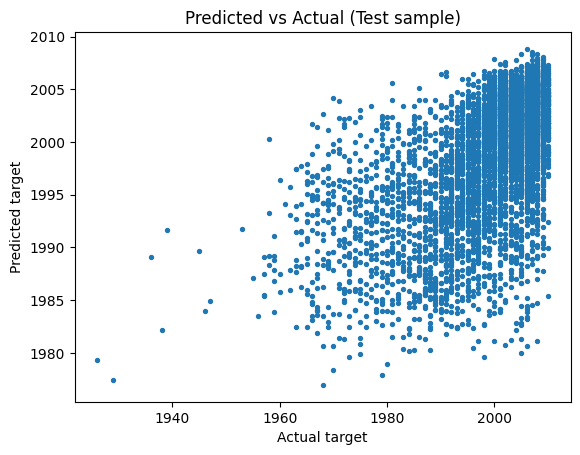

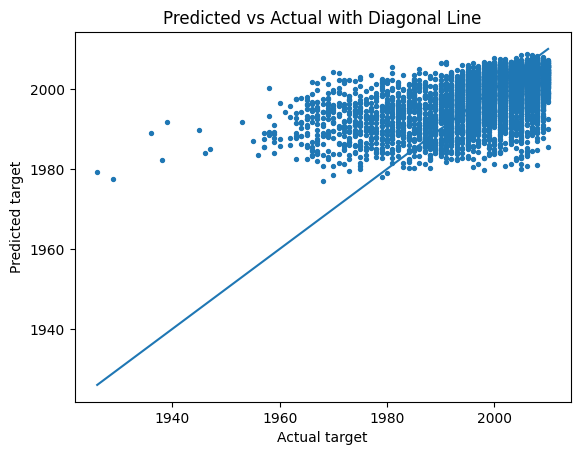

In [15]:
n_plot = min(5000, len(y_test))
idx = np.random.RandomState(42).choice(len(y_test), size=n_plot, replace=False)

y_true_s = y_test.iloc[idx].to_numpy()
y_pred_s = pred_test[idx]

plt.figure()
plt.scatter(y_true_s, y_pred_s, s=8)
plt.title("Predicted vs Actual (Test sample)")
plt.xlabel("Actual target")
plt.ylabel("Predicted target")
plt.show()

# garis diagonal (opsional)
plt.figure()
plt.scatter(y_true_s, y_pred_s, s=8)
mn = min(y_true_s.min(), y_pred_s.min())
mx = max(y_true_s.max(), y_pred_s.max())
plt.plot([mn, mx], [mn, mx])
plt.title("Predicted vs Actual with Diagonal Line")
plt.xlabel("Actual target")
plt.ylabel("Predicted target")
plt.show()


# Interpretation (Brief)

- Baseline (predict mean) memberi patokan performa minimum.
- Ridge Regression biasanya lebih baik dari baseline karena memanfaatkan hubungan linear antar fitur.
- Model boosting (HistGradientBoosting) umumnya memberikan performa terbaik untuk data tabular karena mampu menangkap hubungan non-linear.
- Tuning dasar membantu mencari kombinasi hyperparameter yang menurunkan error (RMSE/MAE) dan meningkatkan R².

**Metrics meaning:**
- MAE: rata-rata selisih absolut prediksi terhadap nilai asli.
- RMSE: menghukum error besar lebih kuat daripada MAE.
- R²: proporsi variasi target yang bisa dijelaskan model (lebih tinggi lebih baik).
